# L-Systems and Spectral Filtering in Ableton Live

### Written by Brian Tice
### University of California, San Diego

This python notebook is used to evaluate the use of L-Systems as a source for spectral filter parameters in a musical collaboration with Tim Gmeiner. We explore the idea that Lindenmayer systems, or L-Systems can be used to generate particular sequences of numbers that are then sent to a Max patch written for Ableton Live. Attention to a human centered approach is paramount because we didn't want the algorithmic approach to impede on the human qualities of the music. In other words, generative algorithms are merely a tool to add color to the music and are not used to generate music.

Within the context of our musical collaboration, I created an audio patch that utilizes L-systems to define the parameters of a filter applied to the drums. In particular, spectral envelope levels of a 256 band spectral filter are defined by the results of an L-System. The patch takes integer text input generated from an L-system, and then maps it to spectral band amplitudes of the filter. A visual representation is also generated in the patch. There is also an ability to live code new L-systems, or any sequence for that matter, and send them via an OSC connection to the patch. Lastly, there exist preset L-System results that can be applied via a knob and three preset buttons. Enjoy and please send any feedback to: btice@ucsd.edu

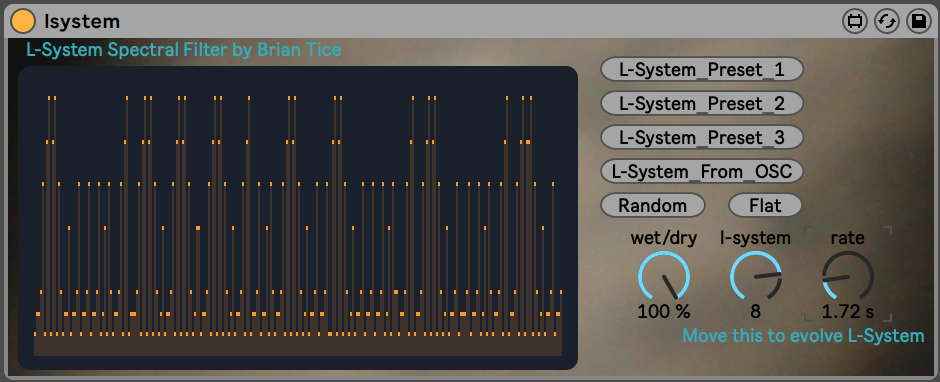

Credit must be given to CNMAT for their OSC max objects as well as to Zack Settel and Cort Lippe for their paper, "Real-Time Musical Applications using FFT-based Resynthesis", that inspired the Spectral Filter Max for Live patch that we modified for our work. 

## L-Systems  

The L-System works with a set of letters, called an alphabet consisting of the letters A through L. The algorithm then interprets production rules over the number of iterations, all starting from the declared axiom. Next, the output string is remapped to a series of integer values with a range of 0-127 because this is the range of a given freqency band level in the filter. In total, 256 integers are calulated in the sequence because this is the number of bands in the spectral filter. The mapping is currently linear between alphabet and integer representation, and is defined to be the following:

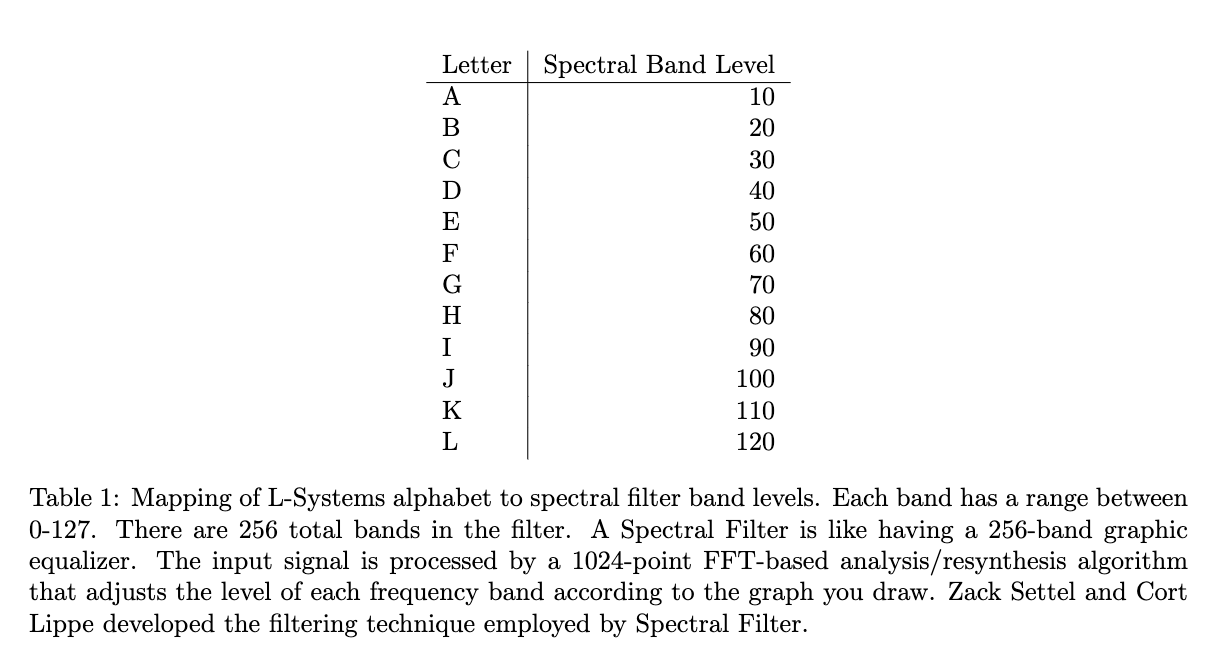

The code is written to be run sequentially in the notebook. 

First, our variables are defined. This includes a list of python dictionaries called production_rules. Each list element consists of a complete dictionary of the production rules for a particular L-system. The alphabet list variable defines the set of available words for our system. The alphabet_to_int_mapping list variable defines our mapping from letters to integers, keeping in mind that the range of a given frequency bin envelope is between 0 and 127.

Next, our L-System functions are defined that allow for the creation of output strings. In addition, there is some intricate timing involved in sending the OSC messages to ableton. The idea is that there is a sweeping transition between successive L-System lists. The rate of transmission is weighted, having lower frequency bins transition more slowly than the higher frequency bands. This is an aesthetic choice. In general, there is room for sonic exploration here with various parametrization methods.



In [169]:
# Pythonosc library module that does not require the sender and receiver of the message to be directly connected 
from pythonosc import dispatcher
# Pythonosc library module that imports a server capable of receiving messages in OSC format 
from pythonosc import osc_server
import time

from pythonosc.udp_client import SimpleUDPClient

ip = "127.0.0.1"
port = 7400

client = SimpleUDPClient(ip, port)  # Create client

In [ ]:
# Each successive production rule adds one word of the alphabet to a successor
production_rules = [{ "A" : "ABC" ,   "B" : "AL",  "C":"AC",  "D":"DIH"},
                    { "A" : "ABBC" ,  "B" : "AL",  "C":"AC",  "D":"DIH"},
                    { "A" : "ABBC" ,  "B" : "AJL", "C":"AC",  "D":"DIH"},
                    { "A" : "ABBC" ,  "B" : "AJL", "C":"AHC", "D":"DIH"},
                    { "A" : "ABBC" ,  "B" : "AJL", "C":"AHC", "D":"DBIH"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "AB"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "AAB"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "ABB"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "ABC"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "ABD"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "ABF"},
                    { "A" : "ABBCH" , "B" : "AJL", "C":"AHC", "D":"DBIH", "H" : "ABH"},]

# This defines the alphabet available to the L-System
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L']

# This defines the mapping from alphabet to integer values with range 0 to 127
alphabet_to_int_mapping = [10,20,30,40,50,60,70,80,90,100,110,120]

# s: initial axiom
# n: number of iterations
# r: production rule index
# returns: resulting string
def lSysGenerate(s, n, r):
    for i in range(n):
        s = lSysCompute(s,r)
    return s

# s: axiom
# r: production rule index
# returns: updated substring
def lSysCompute(s,r):
    new = ''
    for c in s:
        for predecessor, successor in production_rules[r].items():        
            if c == predecessor:
                new += successor
    return new

# l: list of alphabet based data
# returns: list of integers intended for setting spectral amplitudes
def lookup_spectral_amp(l):
    
    data = []
    
    # Map letters to numbers between 0 and 127
    for i in range(256):
        for j in range(12):
            if (l[i] == alphabet[j]): data.append(alphabet_to_int_mapping[j])
                    
    return data

# This is the initial starting axiom for the L-System
axiom = 'A'

# This is the number of iterations to perform when generating the L-System
n = 8

# iterate through the production rules and send the resulting data via osc, with timing delays and blending between transmissions
for y in range(11):
    
    result_1 = lSysGenerate(axiom, n, y) 
    data_1 = lookup_spectral_amp(result_1)

    result_2 = lSysGenerate(axiom, n, y+1) 
    data_2 = lookup_spectral_amp(result_2)

    combined = []
    combined = data_1;

    
    # slowly combine the two, sending out each step along the way
    for x in range(64):
   
        combined[4*x+0] = data_2[4*x+0]
        combined[4*x+1] = data_2[4*x+1]
        combined[4*x+2] = data_2[4*x+2]
        combined[4*x+3] = data_2[4*x+3]
   
        for j in range(256):
            client.send_message("/lsystem", int(combined[j]))   # Send float message
        
        # Go more slowly through the lower frequencies
        if(x < 20):   time.sleep(.1)
        
        # Speed up through the higher frequencies
        elif(x < 64): time.sleep(.05)
    

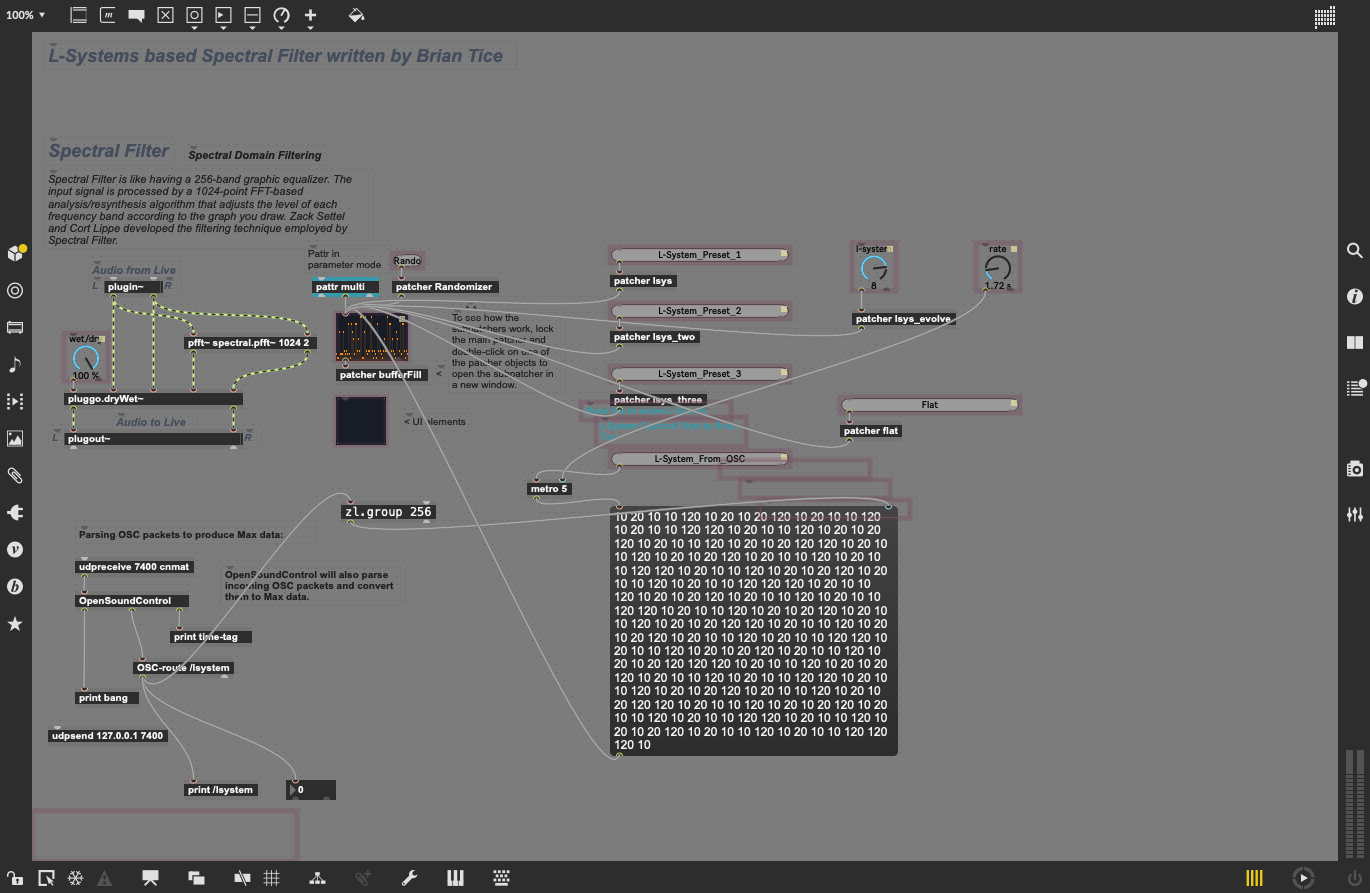